# **Data Understanding**

In [43]:
import pandas as pd

# Load the dataset
data = pd.read_csv('./dataset/data.csv', engine='python', encoding='ISO-8859-1')

# Show top 5 datas
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


The Dataset was imported from kaggle. The dataset itself is telling us about simple e-commerce transaction historical data. Here's some details about each column from the dataset,

- **InvoiceNo**: A unique identifier for each transaction or invoice. It helps in tracking sales records and analyzing purchase patterns.
- **StockCode**: A unique code assigned to each product, which can be used to identify and categorize different items in the inventory.
- **Description**: A textual description of the product purchased. This column provides insights into product demand and popular items.
- **Quantity**: The number of units of a product purchased in a specific transaction. Negative values in this column may indicate product returns.
- **InvoiceDate**: The exact date and time when the transaction took place. It is useful for time-series analysis and identifying seasonal trends in sales.
- **UnitPrice**: The price per unit of the product purchased. This column helps in revenue calculations and price trend analysis.
- **CustomerID**: A unique identifier assigned to each customer. It is crucial for customer segmentation, behavior analysis, and retention strategies.
- **Country**: The country where the customer is located. This column is useful for geographic analysis of sales and market segmentation.

In [44]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **Data Cleaning**

In [45]:
# Parsing CustomerID into string, regarding its purpose as identifier
data['CustomerID'] = data['CustomerID'].astype(str)

In [46]:
# Check for duplicated values
total_data = len(data)
total_duplicates = data.duplicated().sum()
percentage_duplicates = (total_duplicates / total_data) * 100
print(percentage_duplicates)

0.9721189350979592


Since we only have few duplicated rows in the dataset and duplicated values itself does not relevant with the business logic, so we can securely drop them.

In [47]:
# Drop duplicated values
data = data.drop_duplicates()
total_data = len(data)
total_duplicates = data.duplicated().sum()
percentage_duplicates = (total_duplicates / total_data) * 100
print(percentage_duplicates)

0.0


In [48]:
# Check for missing values
data.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [49]:
# Find invoices where some rows have missing CustomerID and others do not
invoice_with_mixed_ids = data.groupby('InvoiceNo')['CustomerID'].transform(lambda x: x.isnull().any() and x.notnull().any())

# Filter dataset to show only these invoices
data_filtered = data[invoice_with_mixed_ids]

# Display the affected invoices
print("Invoices where some rows have missing CustomerID while others have valid values:")
print(data_filtered[['InvoiceNo', 'CustomerID']].sort_values(by="InvoiceNo").head(20))  # Display first 20 rows for preview

Invoices where some rows have missing CustomerID while others have valid values:
Empty DataFrame
Columns: [InvoiceNo, CustomerID]
Index: []


In [50]:
# Show the number of missing CustomerID values per country
print(data[data['CustomerID'].isnull()]['Country'].value_counts())


Series([], Name: count, dtype: int64)


In [51]:
# Show the Customer Ids with missing value by StockCode
print(data[data['CustomerID'].isnull()]['StockCode'].value_counts().head(10))

Series([], Name: count, dtype: int64)


Since we haven't find the pattern for missing Customer Ids and we don't have enough information about where are the missing values come from, we can assume if those customers who don't have Id as a guest who make only one transaction. 

In [52]:
# Correctly fill missing CustomerID with 'Guest'
data['CustomerID'] = data['CustomerID'].fillna('Guest')

# Check remaining missing values
print(data.isna().sum())


InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64


In [53]:
# Count unique descriptions per StockCode
stockcode_check = data.groupby('StockCode')['Description'].nunique()

# Identify StockCodes with more than one description (potential inconsistencies)
inconsistent_stockcodes = stockcode_check[stockcode_check > 1]

# If there are StockCodes with different descriptions, display their details
if not inconsistent_stockcodes.empty:
    # Count the occurrences of each description for each StockCode
    inconsistent_details = (
        data[data['StockCode'].isin(inconsistent_stockcodes.index)]
        .groupby(['StockCode', 'Description'])
        .size()
        .reset_index(name='Count')  # Add Count column
        .sort_values(by=['StockCode', 'Count'], ascending=[True, False])  # Sort by StockCode and Count
    )

    # Print the results
    print("StockCodes with Multiple Descriptions and Their Counts:")
    for stockcode, group in inconsistent_details.groupby('StockCode'):
        print(f"\nStockCode: {stockcode}")
        for _, row in group.iterrows():
            print(f"  - {row['Description']} ({row['Count']} occurrences)")
else:
    print("No StockCodes with multiple descriptions found.")


StockCodes with Multiple Descriptions and Their Counts:

StockCode: 10080
  - GROOVY CACTUS INFLATABLE (22 occurrences)
  - check (1 occurrences)

StockCode: 10133
  - COLOURING PENCILS BROWN TUBE (197 occurrences)
  - damaged (1 occurrences)

StockCode: 15058A
  - BLUE POLKADOT GARDEN PARASOL (93 occurrences)
  - wet/rusty (1 occurrences)

StockCode: 15058C
  - ICE CREAM DESIGN GARDEN PARASOL (72 occurrences)
  - wet/rusty (1 occurrences)

StockCode: 16008
  - SMALL FOLDING SCISSOR(POINTED EDGE) (70 occurrences)
  - check (1 occurrences)

StockCode: 16045
  - POPART WOODEN PENCILS ASST (69 occurrences)
  - check (1 occurrences)

StockCode: 16156L
  - WRAP CAROUSEL (14 occurrences)
  - WRAP, CAROUSEL (4 occurrences)

StockCode: 16162M
  - THE KING GIFT BAG 25x24x12cm (8 occurrences)
  - alan hodge cant mamage this section (1 occurrences)

StockCode: 16168M
  - FUNKY MONKEY GIFT BAG MEDIUM (41 occurrences)
  - found (1 occurrences)

StockCode: 16169E
  - WRAP 50'S  CHRISTMAS (152 occurr

In [54]:
# Create a mapping of the most frequent description for each StockCode
most_frequent_desc = data.groupby('StockCode')['Description'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Replace NaN values in the 'Description' column with the most frequent description for the same StockCode
data['Description'] = data.apply(lambda row: most_frequent_desc.get(row['StockCode'], row['Description']) if pd.isna(row['Description']) else row['Description'], axis=1)

In [55]:
data.isna().sum()

InvoiceNo        0
StockCode        0
Description    112
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
dtype: int64

We can safely fill the remaining missing values in the Description column with the **Unknown** placeholder, because it means that the **StockCode** is only have **NaN** description.

In [56]:
# Correctly fill missing product descriptions with 'Unknown'
data['Description'] = data['Description'].fillna('Unknown')

# Check remaining missing values
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [57]:
# Calculate the percentage of total rows that have minus value for each numeric column
numeric_columns = data.select_dtypes(include=['number']).columns
percentage_negative_values = (data[numeric_columns] < 0).mean() * 100

print(percentage_negative_values)

Quantity     1.972827
UnitPrice    0.000373
dtype: float64


The business logic itself is allowing if the 'Quantity' or 'UnitPrice' to have minus value. It could means the customer is doing the return process. So in that case, we don't have to clean the data.   

# **EDA (Exploratory Data Analysis)**

In [58]:
# Show top 5 rows 
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [59]:
# Adding sales column
data['Sales'] = data['Quantity'] * data['UnitPrice']

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [60]:
# Ensure InvoiceDate is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract year and month for aggregation
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


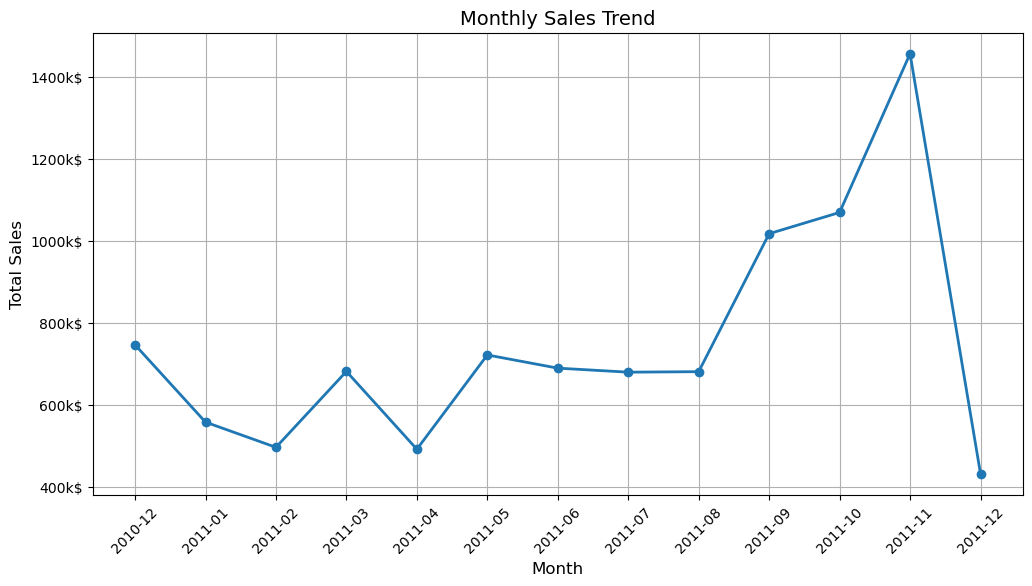

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Group by YearMonth and sum sales
monthly_sales = data.groupby('YearMonth')['Sales'].sum()

# Plot line chart
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linestyle='-', linewidth=2)

# Formatting the chart
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.title("Monthly Sales Trend", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format Y-axis to display in "100k$" format
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e3:.0f}k$'))

plt.grid(True)
plt.show()

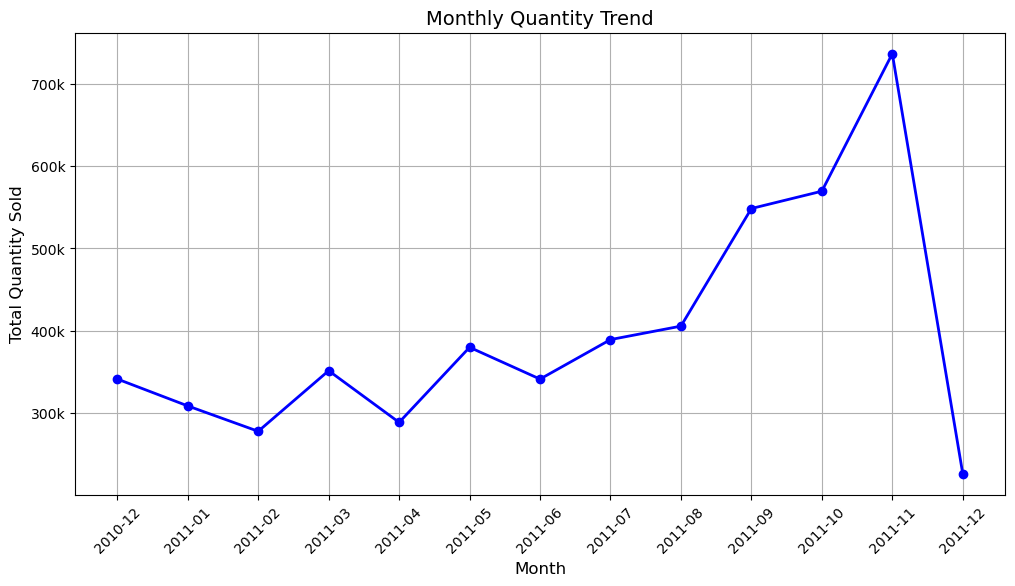

In [62]:
# Group by YearMonth and sum quantity
monthly_quantity = data.groupby('YearMonth')['Quantity'].sum()

# Plot line chart
plt.figure(figsize=(12,6))
plt.plot(monthly_quantity.index.astype(str), monthly_quantity.values, marker='o', linestyle='-', linewidth=2, color='blue')

# Formatting the chart
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Quantity Sold", fontsize=12)
plt.title("Monthly Quantity Trend", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format Y-axis to display in "10k" format
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e3:.0f}k'))

plt.grid(True)
plt.show()

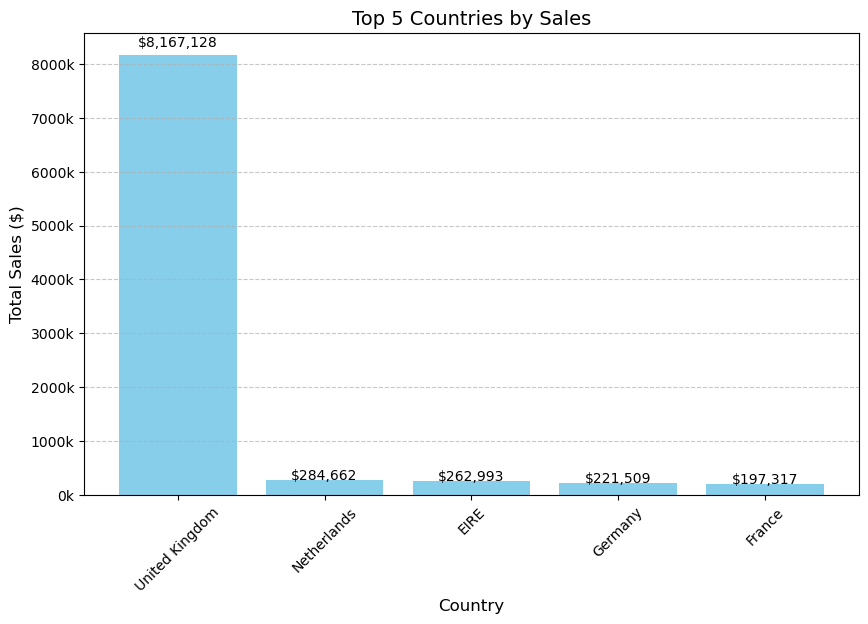

In [63]:
# Group by country and sum sales
top_countries = data.groupby('Country')['Sales'].sum().sort_values(ascending=False).head(5)

# Plot bar chart
plt.figure(figsize=(10,6))
plt.bar(top_countries.index, top_countries.values, color='skyblue')

# Formatting the chart
plt.xlabel("Country", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.title("Top 5 Countries by Sales", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format Y-axis to display in "10k" format
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e3:.0f}k'))

# Show values on top of bars
for i, value in enumerate(top_countries.values):
  plt.text(i, value + (value * 0.02), f"${value:,.0f}", ha='center', fontsize=10)

plt.show()

In [64]:
# Calculate the mode (most frequent value) for each StockCode
most_frequent_desc = data.groupby('StockCode')['Description'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Add a new column 'ProductName' containing the mode based on StockCode
data['ProductName'] = data['StockCode'].map(most_frequent_desc)

In [65]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth,ProductName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,WHITE METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,RED WOOLLY HOTTIE WHITE HEART.


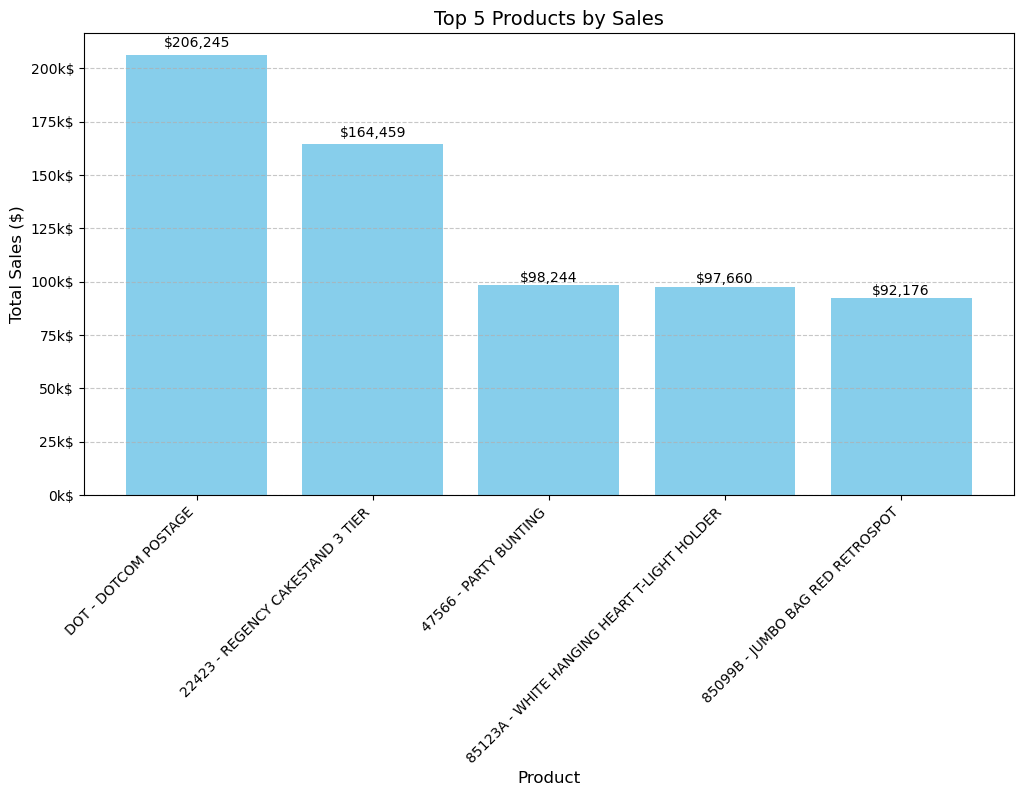

In [66]:
# Aggregate sales by StockCode and ProductName
top_products = data.groupby(['StockCode', 'Description'])['Sales'].sum().sort_values(ascending=False).head(5)

# Convert MultiIndex to a single column
top_products = top_products.reset_index()

# Combine StockCode and ProductName for labels
top_products['Label'] = top_products['StockCode'] + " - " + top_products['Description']

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_products['Label'], top_products['Sales'], color='skyblue')

# Formatting the chart
plt.xlabel("Product", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.title("Top 5 Products by Sales", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format Y-axis to display in "10k" format
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e3:.0f}k$'))

# Show values on top of bars
for index, value in enumerate(top_products['Sales']):
    plt.text(index, value + (value * 0.02), f"${value:,.0f}", ha='center', fontsize=10)

# Show the plot
plt.show()

In [67]:
# Create a new table including CustomerID, Sales, and Country
customer_sales_data = data[['CustomerID', 'Sales', 'Country']].copy()

# Separate Guest customers and regular customers
regular_customers = customer_sales_data[customer_sales_data['CustomerID'] != 'Guest']
guest_customers = customer_sales_data[customer_sales_data['CustomerID'] == 'Guest']

# Group by CustomerID and aggregate Sales (sum of sales per customer) only for regular customers
grouped_regular_customers = regular_customers.groupby(['CustomerID', 'Country'])['Sales'].sum().reset_index()

# Combine the grouped regular customers with individual Guest records
final_customer_sales_data = pd.concat([grouped_regular_customers, guest_customers], ignore_index=True)

In [68]:
final_customer_sales_data.head()

,CustomerID,Country,Sales
0,12346.0,United Kingdom,0.00
1,12347.0,Iceland,4310.00
2,12348.0,Finland,1797.24
3,12349.0,Italy,1757.55
4,12350.0,Norway,334.40


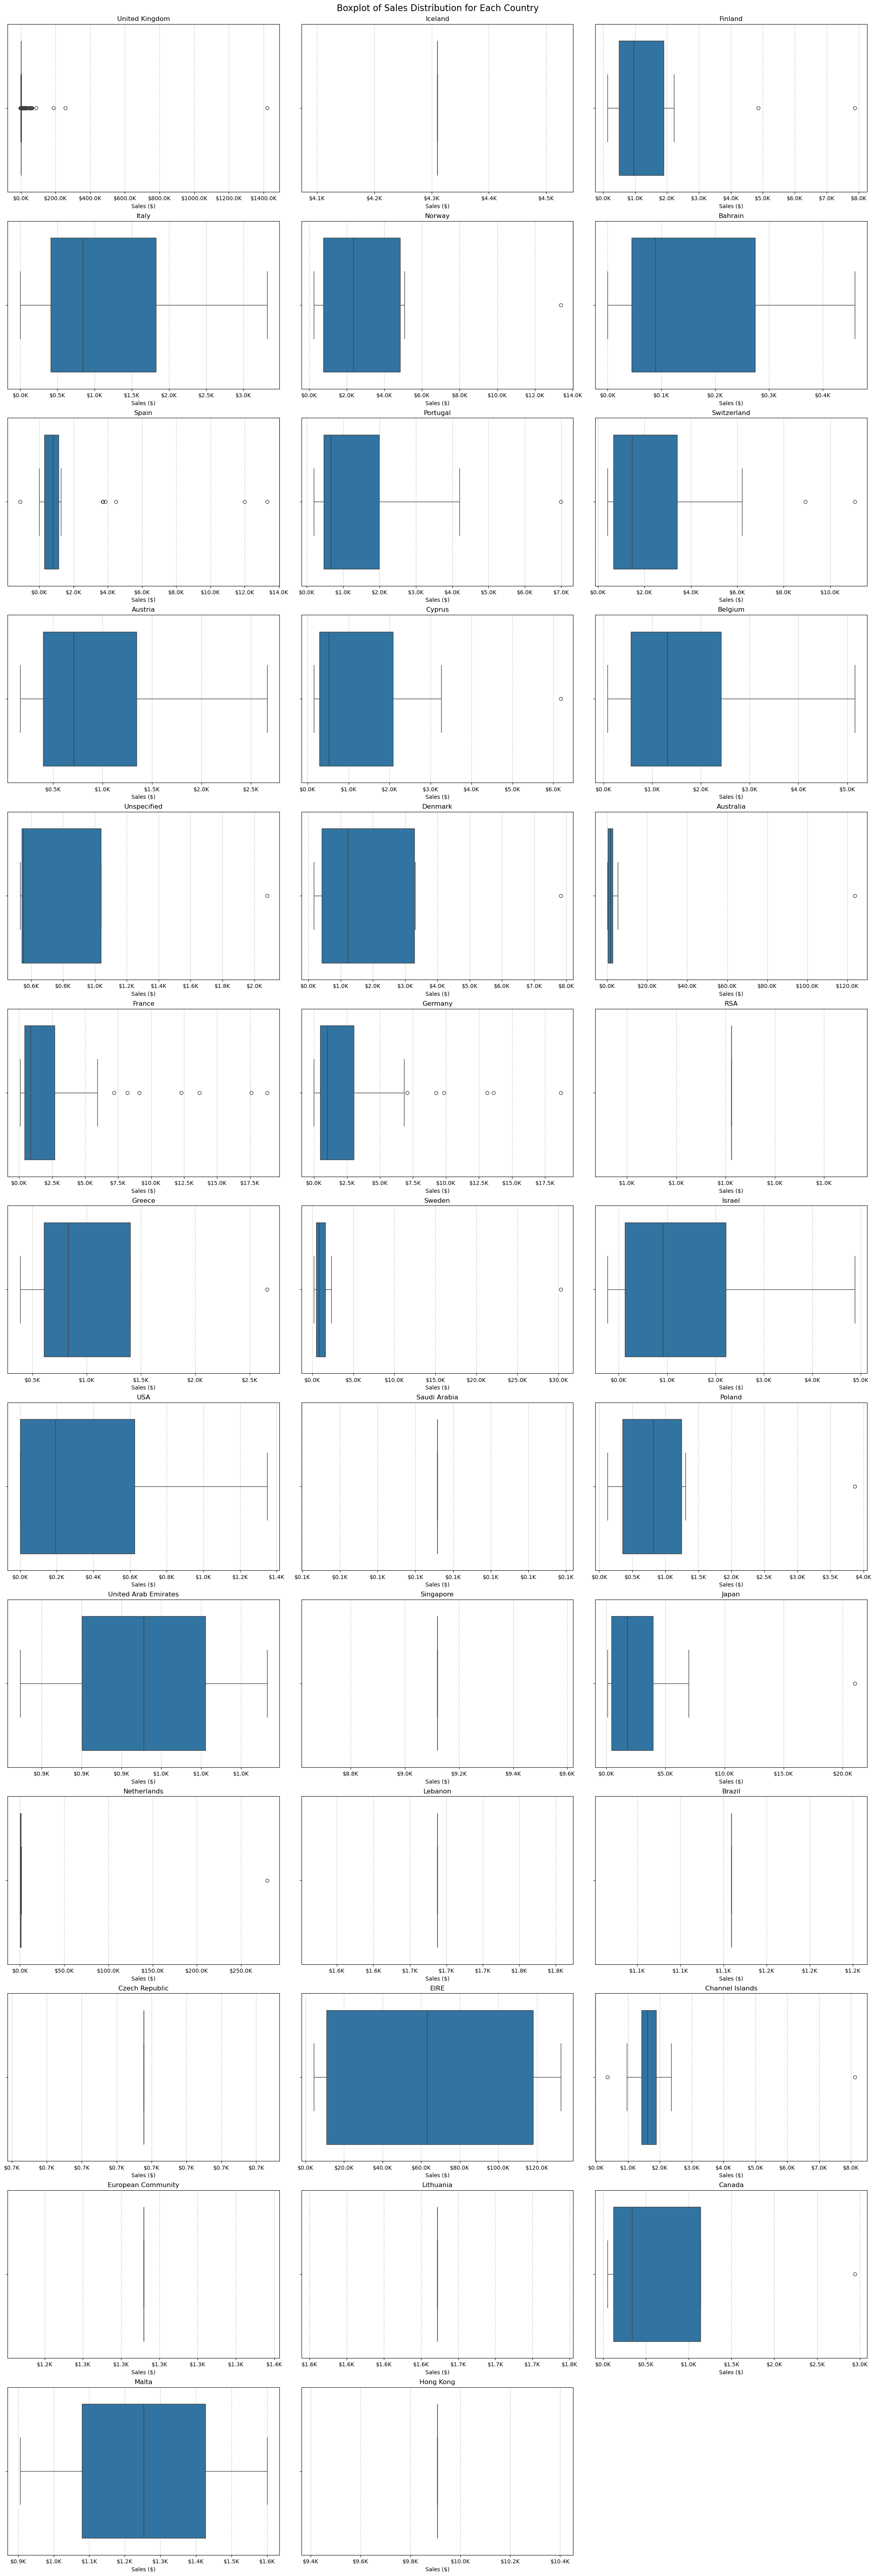

In [69]:
import seaborn as sns
import math

# Define number of rows and columns for subplots
num_countries = final_customer_sales_data['Country'].nunique()
num_cols = 3  # Number of columns per row
num_rows = math.ceil(num_countries / num_cols)  # Calculate required rows

# Create subplots with a longer figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, num_rows * 5), constrained_layout=True)
axes = axes.flatten()  # Flatten to handle extra spaces

# Plot each country's boxplot in its own subplot
for idx, country in enumerate(final_customer_sales_data['Country'].unique()):
    ax = axes[idx]
    sns.boxplot(
        x=final_customer_sales_data[final_customer_sales_data['Country'] == country]['Sales'],
        ax=ax,
        showfliers=True
    )
    ax.set_title(country, fontsize=12)
    ax.set_xlabel("Sales ($)", fontsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Format X-axis values in "K" format with 1 decimal place and dollar sign
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1e3:.1f}K'))

# Remove empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Show plot
plt.suptitle("Boxplot of Sales Distribution for Each Country", fontsize=16)
plt.show()


In [70]:
# Function to clean outliers using the IQR method per country
def remove_outliers_by_country(df, column, group_by_col):
    """
    Removes outliers from a specified column in a DataFrame using the IQR method,
    applied separately for each country (or any specified group).
    """
    def iqr_filter(sub_df):
        Q1 = sub_df[column].quantile(0.25)
        Q3 = sub_df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for filtering
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        return sub_df[(sub_df[column] >= lower_bound) & (sub_df[column] <= upper_bound)]

    # Apply the IQR filter separately for each country
    cleaned_df = df.groupby(group_by_col, group_keys=False).apply(iqr_filter)
    
    return cleaned_df

# Apply outlier removal for Sales per Country
final_customer_sales_cleaned_data = remove_outliers_by_country(final_customer_sales_data, 'Sales', 'Country')

# Print summary of changes
print(f"Original customer sales data size: {len(final_customer_sales_data)}")
print(f"Cleaned customer sales data size: {len(final_customer_sales_cleaned_data)}")
print(f"Number of outliers removed: {len(final_customer_sales_data) - len(final_customer_sales_cleaned_data)}")


Original customer sales data size: 4389
Cleaned customer sales data size: 3967
Number of outliers removed: 422


C:\Users\Yuta\AppData\Local\Temp\ipykernel_10024\2371024290.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_df = df.groupby(group_by_col, group_keys=False).apply(iqr_filter)


In [71]:
final_customer_sales_cleaned_data.head()

,CustomerID,Country,Sales
34,12386.0,Australia,401.90
35,12388.0,Australia,2780.66
38,12393.0,Australia,1582.60
63,12422.0,Australia,386.20
66,12424.0,Australia,1760.96


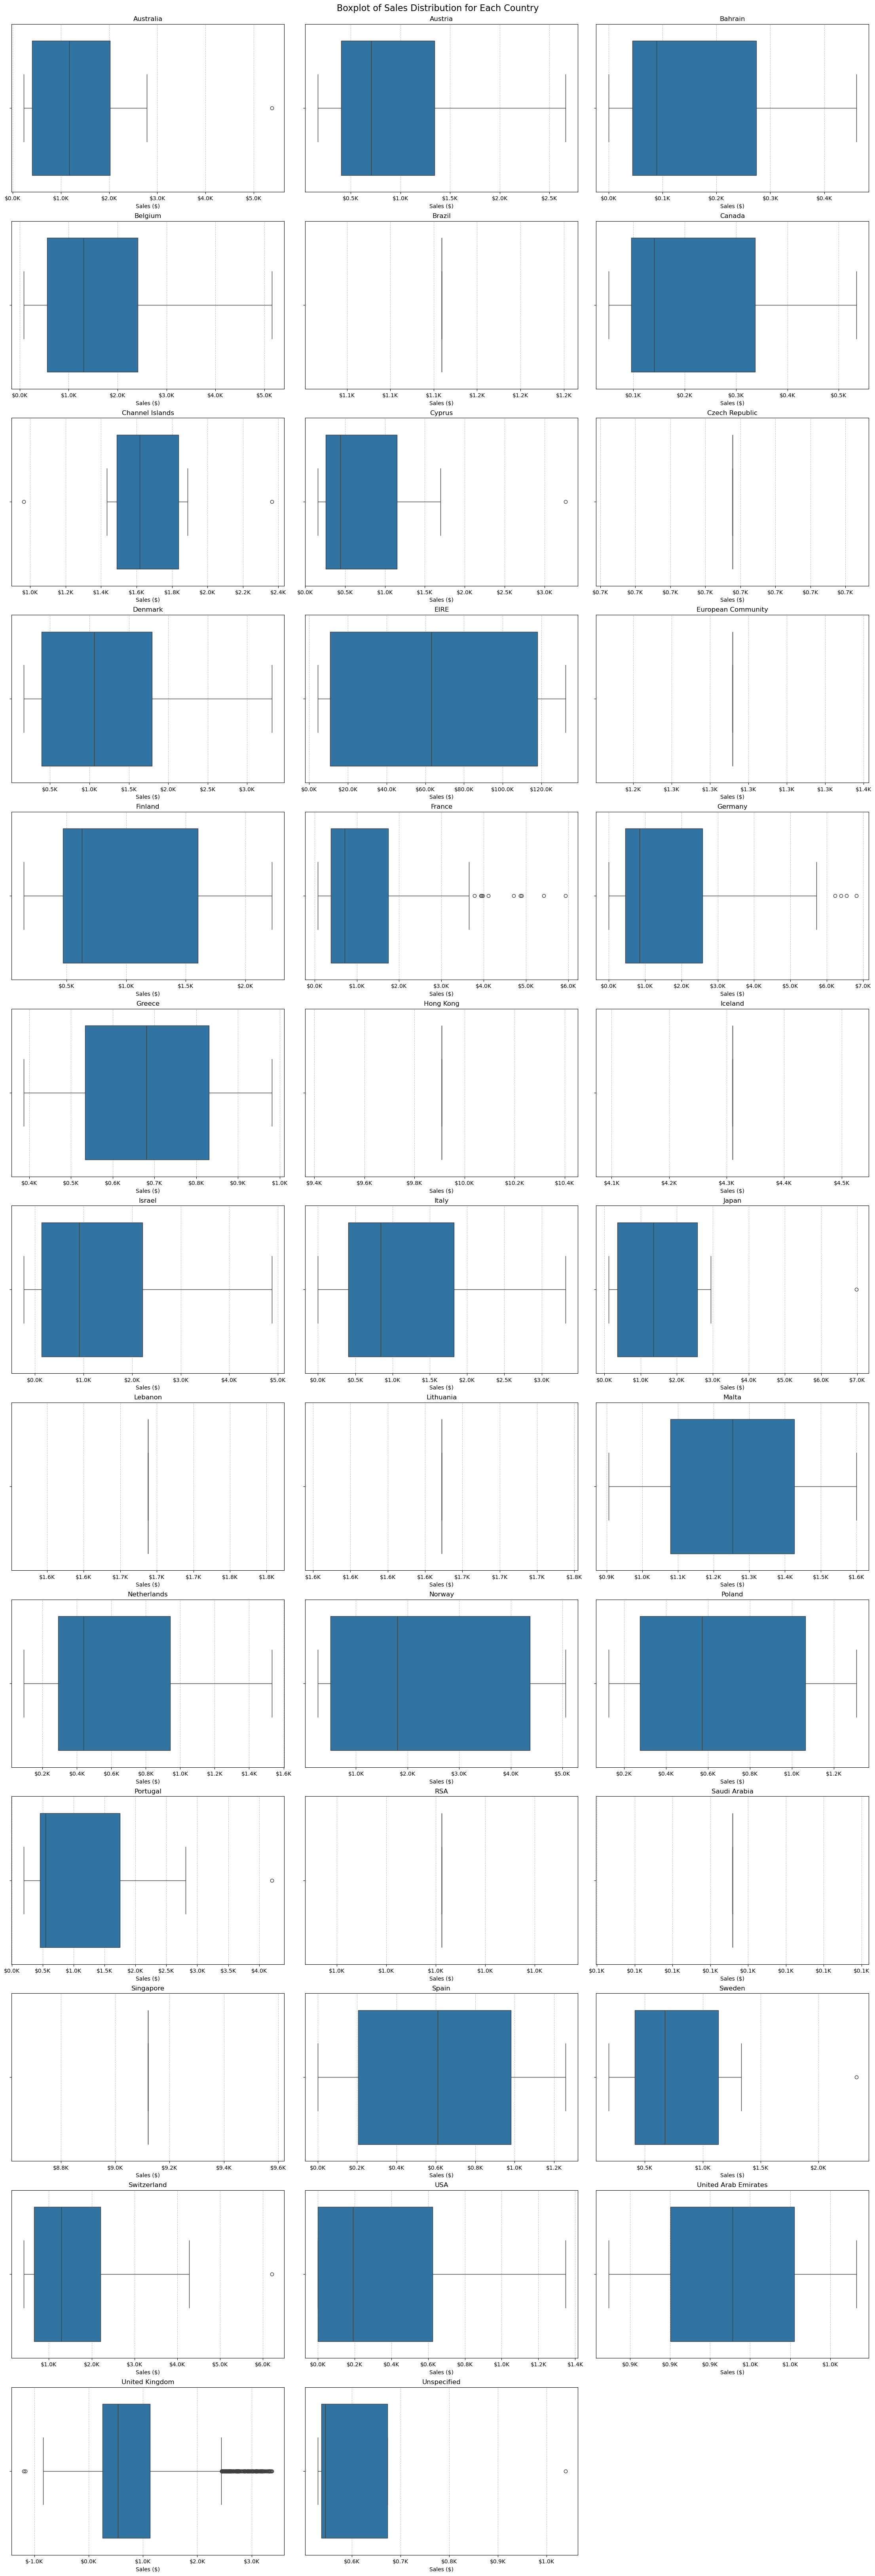

In [72]:
# Define number of rows and columns for subplots
num_countries = final_customer_sales_cleaned_data['Country'].nunique()
num_cols = 3  # Number of columns per row
num_rows = math.ceil(num_countries / num_cols)  # Calculate required rows

# Create subplots with a longer figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, num_rows * 5), constrained_layout=True)
axes = axes.flatten()  # Flatten to handle extra spaces

# Plot each country's boxplot in its own subplot
for idx, country in enumerate(final_customer_sales_cleaned_data['Country'].unique()):
    ax = axes[idx]
    sns.boxplot(
        x=final_customer_sales_cleaned_data[final_customer_sales_cleaned_data['Country'] == country]['Sales'],
        ax=ax,
        showfliers=True
    )
    ax.set_title(country, fontsize=12)
    ax.set_xlabel("Sales ($)", fontsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Format X-axis values in "K" format with 1 decimal place and dollar sign
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1e3:.1f}K'))

# Remove empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Show plot
plt.suptitle("Boxplot of Sales Distribution for Each Country", fontsize=16)
plt.show()


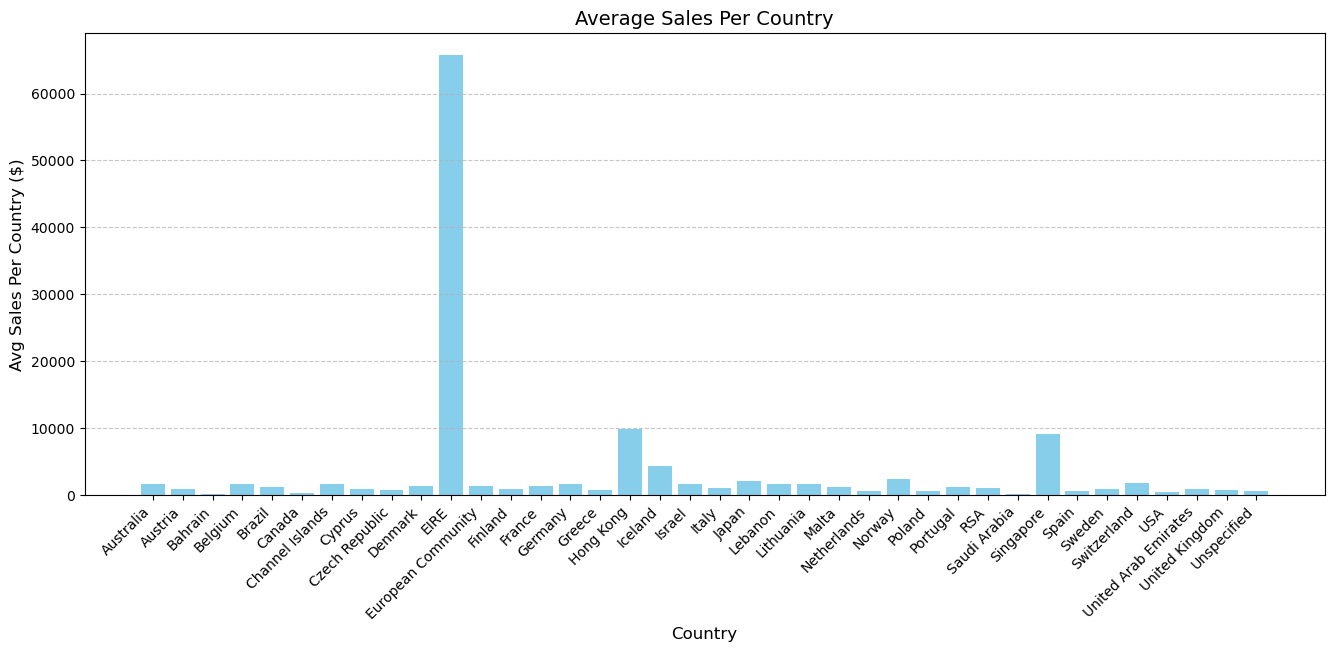

In [73]:
# Calculate the average sales per country
avg_sales_by_country = final_customer_sales_cleaned_data.groupby('Country')['Sales'].mean().reset_index()

# Plot column chart
plt.figure(figsize=(16, 6))
plt.bar(avg_sales_by_country['Country'], avg_sales_by_country['Sales'], color='skyblue')

# Formatting the chart
plt.xlabel("Country", fontsize=12)
plt.ylabel("Avg Sales Per Country ($)", fontsize=12)
plt.title("Average Sales Per Country", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Based on the visualization, we can conclude that UK may have the most sales than the others. But, countries like EIRE, Hong Kong, and Singapore have significantly more valuable customers.

# **Cohort Analysis**

In [74]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth,ProductName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,WHITE METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,RED WOOLLY HOTTIE WHITE HEART.


In [75]:
# Define the first purchase month for each customer
cohorts = data.groupby('CustomerID')['YearMonth'].min().reset_index()
cohorts.columns = ['CustomerID', 'FirstCohort']
cohorts.head()

,CustomerID,FirstCohort
0,12346.0,2011-01
1,12347.0,2010-12
2,12348.0,2010-12
3,12349.0,2011-11
4,12350.0,2011-02


In [76]:
# Merge the first purchase month with the original data
data = data.merge(cohorts, on='CustomerID', how='left')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth,ProductName,FirstCohort
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,WHITE HANGING HEART T-LIGHT HOLDER,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,WHITE METAL LANTERN,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,CREAM CUPID HEARTS COAT HANGER,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,RED WOOLLY HOTTIE WHITE HEART.,2010-12


In [77]:
# Define all unique YearMonth values in the dataset
headers = data['YearMonth'].value_counts().reset_index()
headers.columns = ['YearMonth', 'Count']

# Sort YearMonth values
headers = headers.sort_values(['YearMonth'])

# Convert YearMonth column to a list for better readability
headers_list = headers['YearMonth'].tolist()

# Display formatted output
print("Unique YearMonth values in dataset:")
for ym in headers_list:
    print(ym)


Unique YearMonth values in dataset:
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12


In [78]:
# Calculate the distance of each transaction month from the first purchase month
data['CohortDistance'] = data.apply(lambda row: (headers_list.index(row['YearMonth'])-headers_list.index(row['FirstCohort'])) if (row['FirstCohort'] !=0 and row['YearMonth'] !=0) else np.nan, axis=1)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth,ProductName,FirstCohort,CohortDistance
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,WHITE HANGING HEART T-LIGHT HOLDER,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,WHITE METAL LANTERN,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,CREAM CUPID HEARTS COAT HANGER,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,RED WOOLLY HOTTIE WHITE HEART.,2010-12,0


In [79]:
# Create a cohort pivot table
cohort_pivot = data.pivot_table(
    index="FirstCohort",  # Cohort groups (first purchase month)
    columns="CohortDistance",  # Months since first purchase
    values="CustomerID",  # Count unique customers
    aggfunc=pd.Series.nunique  # Unique customers per cohort-distance
)

cohort_pivot

CohortDistance,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstCohort,,,,,,,,,,,,,
2010-12,949.0,363.0,318.0,368.0,342.0,377.0,361.0,337.0,337.0,375.0,355.0,475.0,261.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Normalize each row by its first cohort value 
cohort_pivot_normalized = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0)
cohort_pivot_normalized

CohortDistance,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstCohort,,,,,,,,,,,,,
2010-12,1.0,0.382508,0.335090,0.387777,0.360379,0.397260,0.380400,0.355111,0.355111,0.395153,0.374078,0.500527,0.275026
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# Show values in percentage
cohort_retention_percentage = cohort_pivot_normalized.mul(100).round(2)
cohort_retention_percentage

CohortDistance,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstCohort,,,,,,,,,,,,,
2010-12,100.0,38.25,33.51,38.78,36.04,39.73,38.04,35.51,35.51,39.52,37.41,50.05,27.5
2011-01,100.0,23.99,28.27,24.23,32.78,29.93,26.13,25.65,31.12,34.68,36.82,14.96,NaN
2011-02,100.0,24.74,19.21,27.89,26.84,24.74,25.53,28.16,25.79,31.32,9.21,NaN,NaN
2011-03,100.0,19.09,25.45,21.82,23.18,17.73,26.36,23.86,28.86,8.86,NaN,NaN,NaN
2011-04,100.0,22.74,22.07,21.07,20.74,23.75,23.08,26.09,8.36,NaN,NaN,NaN,NaN
2011-05,100.0,23.66,17.20,17.20,21.51,24.37,26.52,10.39,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,20.85,18.72,27.23,24.68,33.62,10.21,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,20.94,20.42,23.04,27.23,11.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,25.15,25.15,25.15,13.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


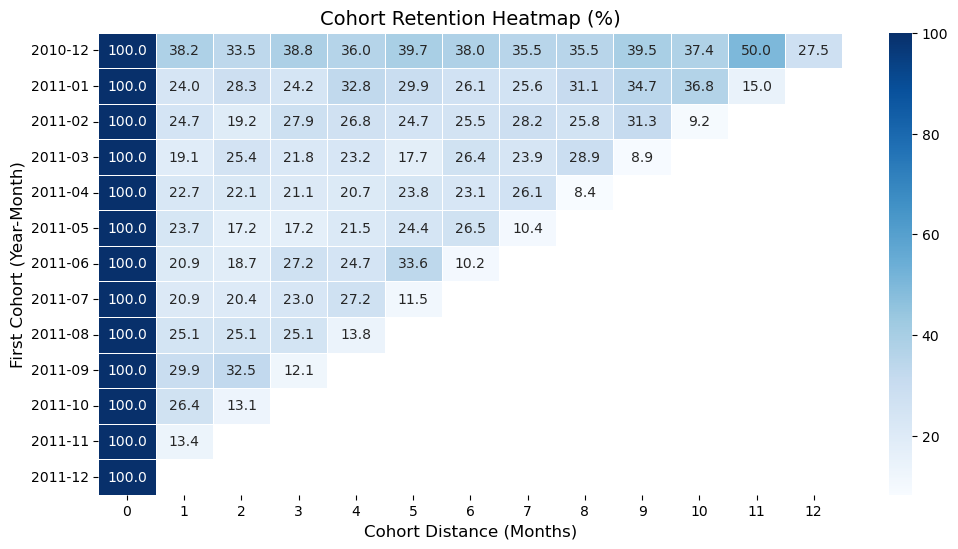

In [82]:
# Visualize the cohort retention table as a heatmap for better visualization

# Set up the figure
plt.figure(figsize=(12, 6))

# Create the heatmap
sns.heatmap(cohort_retention_percentage, annot=True, fmt=".1f", cmap="Blues", linewidths=0.5)

# Labels and title
plt.title("Cohort Retention Heatmap (%)", fontsize=14)
plt.xlabel("Cohort Distance (Months)", fontsize=12)
plt.ylabel("First Cohort (Year-Month)", fontsize=12)

# Show the plot
plt.show()

## **Conclusion**

The cohort analysis suggests that the retail company initially had a strong engagement strategy, as seen in the higher retention rates of early cohorts. However, over time, customer loyalty declined, indicating that the company did not sustain or improve its engagement efforts. Later cohorts experienced faster drop-off rates, suggesting that either customer expectations evolved, competitive pressures increased, or engagement strategies became less effective.

To regain customer loyalty, the company must reassess its retention strategies, identify what worked in the early period, and adapt to changing consumer behaviors. By implementing targeted engagement initiatives, loyalty programs, and personalized re-engagement efforts, the company can improve long-term retention and sustain customer value over time.